In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt 
import matplotlib.pyplot as plt
import pmdarima as pm
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats
import warnings
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold


In [17]:
# Define the ticker symbols
ticker = '000001.SS'
gold_ticker = 'GC=F'  # Gold futures as a proxy
interest_rate_ticker = '^IRX'  # Example for US interest rate (3-Month T-Bill)
usd_cny_ticker = 'CNY=X'  # USD/CNY exchange rate

# Define the date range
start_date = '2014-01-01'
end_date = '2024-01-01'

# Download data
data = yf.download(ticker, start=start_date, end=end_date)
gold_data = yf.download(gold_ticker, start=start_date, end=end_date)
interest_rate_data = yf.download(interest_rate_ticker, start=start_date, end=end_date)
usd_cny_data = yf.download(usd_cny_ticker, start=start_date, end=end_date)

# Merge the data
data['Gold'] = gold_data['Close']
data['Interest_Rate'] = interest_rate_data['Close']
data['USD_CNY'] = usd_cny_data['Close']

# Drop rows with missing values
data.dropna(inplace=True)

# Define a function for train-test split
def train_test_split(X, size=0.8):
    train = X[:int(X.shape[0]*size)]
    test = X[int(X.shape[0]*size):]
    return train, test

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, size=0.8)
y_train = train_data['Close']
y_test = test_data['Close']
test = test_data['Close']

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [18]:
# List of features to be considered for regression
features = ['Gold', 'Interest_Rate', 'USD_CNY']

# Initialize variables to store the best model information
best_mse = float('inf')
best_combination = None
best_model = None

# Define the number of folds for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Loop to add features one by one and find the best combination
for i in range(len(features)):
    current_features = []
    
    for j in range(len(features) - i):
        current_features.append(features[j])
        
        # Initialize variable to store the MSE for the current combination
        mse_scores = []

        for train_index, val_index in kf.split(train_data):
            # Split the training data into train and validation sets
            X_train, X_val = train_data.iloc[train_index][current_features], train_data.iloc[val_index][current_features]
            y_train_fold, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

            # Add constant column manually for both train and validation sets
            X_train = pd.DataFrame(X_train)
            X_train.insert(0, 'const', 1)
            X_val = pd.DataFrame(X_val)
            X_val.insert(0, 'const', 1)
            
            # Fit the model on the training fold
            model = sm.OLS(y_train_fold, X_train).fit()
            
            # Predict on the validation fold
            y_pred = model.predict(X_val)
            
            # Calculate the MSE and store it
            mse = mean_squared_error(y_val, y_pred)
            mse_scores.append(mse)

        # Calculate the average MSE across all folds
        avg_mse = np.mean(mse_scores)

        # Update the best model if this one is better
        if avg_mse < best_mse:
            best_mse = avg_mse
            best_combination = list(current_features)
            best_model = model

# Output the best combination and corresponding MSE
print(f'Best combination of variables: {best_combination}')
print(f'Best MSE: {best_mse}')
print(best_model.summary())


Best combination of variables: ['Gold', 'Interest_Rate']
Best MSE: 234467.09894496025
                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     42.89
Date:                Sun, 25 Aug 2024   Prob (F-statistic):           7.69e-19
Time:                        14:45:04   Log-Likelihood:                -11447.
No. Observations:                1501   AIC:                         2.290e+04
Df Residuals:                    1498   BIC:                         2.292e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

In [19]:
# Suppress specific warning messages
warnings.filterwarnings("ignore", category=UserWarning, module='statsmodels')

In [20]:
best_combination

['Gold', 'Interest_Rate']

1-day Ahead Forecast:
MAE: 40.04451383543055
RMSE: 53.50288831926586
MAPE: 1.2588656152604467%



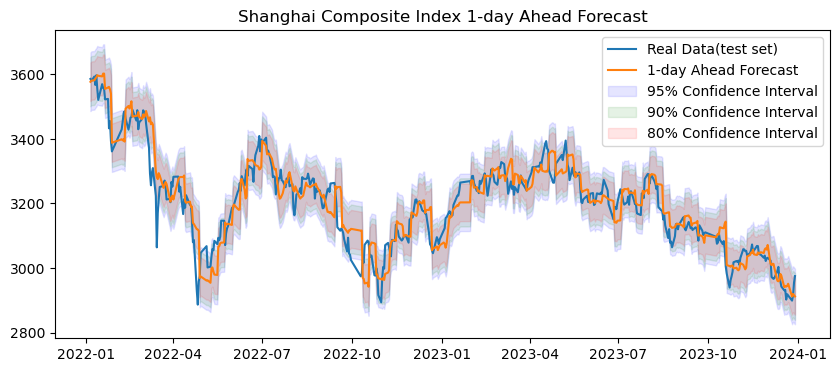

5-days Ahead Forecast:
MAE: 40.371587393464985
RMSE: 54.137127246124734
MAPE: 1.2697193484169889%



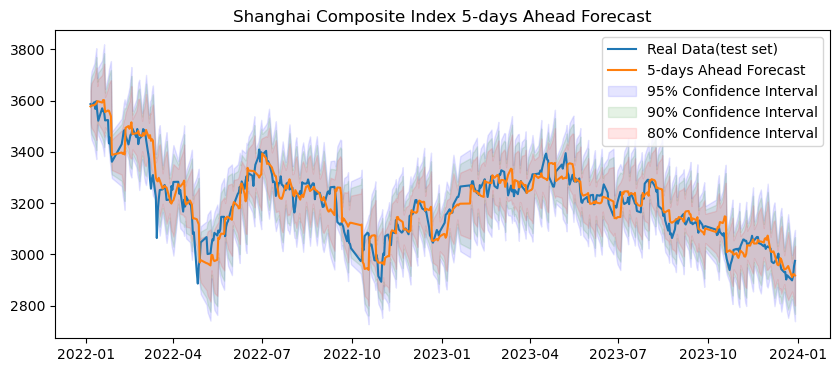

20-days Ahead Forecast:
MAE: 68.07763081068548
RMSE: 91.16993614661389
MAPE: 2.1375514147527452%



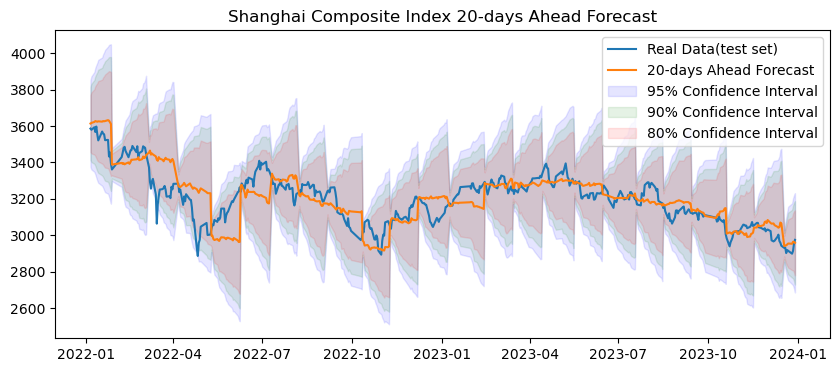

60-days Ahead Forecast:
MAE: 103.31684882869025
RMSE: 137.65608820441506
MAPE: 3.22705722913582%



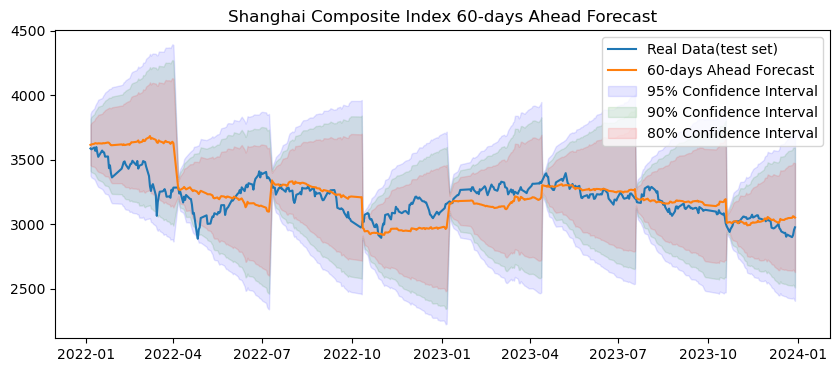

1-day Ahead Forecast:
MAE: 40.04451383543055
RMSE: 53.50288831926586
MAPE: 1.2588656152604467%

5-days Ahead Forecast:
MAE: 40.371587393464985
RMSE: 54.137127246124734
MAPE: 1.2697193484169889%

20-days Ahead Forecast:
MAE: 68.07763081068548
RMSE: 91.16993614661389
MAPE: 2.1375514147527452%

60-days Ahead Forecast:
MAE: 103.31684882869025
RMSE: 137.65608820441506
MAPE: 3.22705722913582%



In [22]:
# Function to perform multi-step forecast with specific confidence level
def multi_step_forecast(n_periods, alpha=0.05):
    arima_forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True, alpha=alpha)
    return (
        arima_forecast.tolist(),
        np.asarray(conf_int).tolist()
    )

# Function to update the regression model and return new residuals
def update_regression_model(data):
    X = data[best_combination]
    X.insert(0, 'const', 1)  # Add constant column
    y = data['Close']
    model = sm.OLS(y, X).fit()
    residuals = y - model.predict(X)
    return model, residuals

# Define a function for re-estimating ARIMA model with new data
def reestimate_arima_model(data):
    return auto_arima(data, trace=False, error_action='ignore', suppress_warnings=True)

# Perform forecasts and evaluations for different periods
forecast_periods = {'1-day': 1, '5-days': 5, '20-days': 20, '60-days': 60}
results = {}

for period_name, n_periods in forecast_periods.items():
    # Creat empty lists for storing results
    reg_predictions = []
    arima_predictions = []
    confidence_intervals_95 = []
    confidence_intervals_90 = []
    confidence_intervals_80 = []
    # Define the ARIMAX model for each time horizon
    current_train_data = train_data.copy()
    updated_regression, updated_res = update_regression_model(current_train_data)
    arima_model = reestimate_arima_model(updated_res)
    # For daily forecast, we choose to re-estimate parameters every 5 forecasts
    reestimate_interval = 5 if period_name == '1-day' else 1
    forecasts_since_last_reestimate = 0

    for i in range(0, len(test), n_periods):
        # Prepare data for regression model prediction
        X_test = test_data.iloc[i:i + n_periods][best_combination]
        X_test.insert(0, 'const', 1)  # Add constant column
        # Perform multi-step forecast
        reg_forecast = updated_regression.predict(X_test)
        arima_forecast_95, conf_95 = multi_step_forecast(n_periods, alpha=0.05)
        arima_forecast_90, conf_90 = multi_step_forecast(n_periods, alpha=0.10)
        arima_forecast_80, conf_80 = multi_step_forecast(n_periods, alpha=0.20)
        
        for j in range(n_periods):
            if i + j < len(test):
                # Store results
                reg_predictions.append(reg_forecast.iloc[j])
                arima_predictions.append(arima_forecast_95[j])
                
                # Adjust confidence intervals by adding regression forecast
                conf_95_adjusted = [conf_95[j][0] + reg_forecast.iloc[j], conf_95[j][1] + reg_forecast.iloc[j]]
                conf_90_adjusted = [conf_90[j][0] + reg_forecast.iloc[j], conf_90[j][1] + reg_forecast.iloc[j]]
                conf_80_adjusted = [conf_80[j][0] + reg_forecast.iloc[j], conf_80[j][1] + reg_forecast.iloc[j]]
                confidence_intervals_95.append(conf_95_adjusted)
                confidence_intervals_90.append(conf_90_adjusted)
                confidence_intervals_80.append(conf_80_adjusted)
        # Update regression model with new data 
        current_train_data = pd.concat([train_data, test_data[:i + n_periods]])
        updated_regression, updated_res = update_regression_model(current_train_data)
        
        # Re-estimate the ARIMA and GARCH models with the updated training sets
        forecasts_since_last_reestimate += 1
        if forecasts_since_last_reestimate >= reestimate_interval:
            arima_model = reestimate_arima_model(updated_res)
            forecasts_since_last_reestimate = 0

    # Combine ARIMAX Forecasts
    reg_forecast_series = pd.Series(reg_predictions[:len(test)], index=test.index[:len(reg_predictions)])
    arima_forecast_series = pd.Series(arima_predictions[:len(test)], index=test.index[:len(arima_predictions)])
    conf_int_df_95 = pd.DataFrame(confidence_intervals_95[:len(test)], index=test.index[:len(arima_predictions)], columns=['lower', 'upper'])
    conf_int_df_90 = pd.DataFrame(confidence_intervals_90[:len(test)], index=test.index[:len(arima_predictions)], columns=['lower', 'upper'])
    conf_int_df_80 = pd.DataFrame(confidence_intervals_80[:len(test)], index=test.index[:len(arima_predictions)], columns=['lower', 'upper'])
    final_forecast = reg_forecast_series + arima_forecast_series

    # Remove the first 5 forecasted values and the corresponding test value
    adjusted_final_forecast = final_forecast[5:]
    adjusted_test = test[5:len(final_forecast)]
    adjusted_conf_int_df_95 = conf_int_df_95.iloc[5:]
    adjusted_conf_int_df_90 = conf_int_df_90.iloc[5:]
    adjusted_conf_int_df_80 = conf_int_df_80.iloc[5:]

    # Evaluate the Forecast after removing the first 5 values
    mae = mean_absolute_error(adjusted_test, adjusted_final_forecast)
    rmse = np.sqrt(mean_squared_error(adjusted_test, adjusted_final_forecast))
    mape = np.mean(np.abs((adjusted_test - adjusted_final_forecast) / adjusted_test)) * 100

    # Store results
    results[period_name] = {
        'forecast': adjusted_final_forecast,
        'confidence_intervals_95': adjusted_conf_int_df_95,
        'confidence_intervals_90': adjusted_conf_int_df_90,
        'confidence_intervals_80': adjusted_conf_int_df_80,
        'mae': mae,
        'rmse': rmse,
        'mape': mape
    }

    # Print the evaluation metrics
    print(f'{period_name.capitalize()} Ahead Forecast:')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}%\n')

    # Plot the results after adjustment
    plt.figure(figsize=(10, 4))
    plt.plot(adjusted_test, label='Real Data(test set)')
    plt.plot(adjusted_final_forecast, label=f'{period_name.capitalize()} Ahead Forecast')

    # Plot different confidence intervals with different colors
    plt.fill_between(adjusted_conf_int_df_95.index, adjusted_conf_int_df_95['lower'], adjusted_conf_int_df_95['upper'], color='b', alpha=0.1, label='95% Confidence Interval')
    plt.fill_between(adjusted_conf_int_df_90.index, adjusted_conf_int_df_90['lower'], adjusted_conf_int_df_90['upper'], color='g', alpha=0.1, label='90% Confidence Interval')
    plt.fill_between(adjusted_conf_int_df_80.index, adjusted_conf_int_df_80['lower'], adjusted_conf_int_df_80['upper'], color='r', alpha=0.1, label='80% Confidence Interval')

    plt.title(f'Shanghai Composite Index {period_name.capitalize()} Ahead Forecast')
    plt.legend()
    plt.show()

# Summarize results for each forecasting period
for period_name, result in results.items():
    print(f"{period_name.capitalize()} Ahead Forecast:")
    print(f"MAE: {result['mae']}")
    print(f"RMSE: {result['rmse']}")
    print(f"MAPE: {result['mape']}%\n")